In [202]:
import numpy as np
import matplotlib.pyplot as plt
import manipulate_text as mt
import os
from astropy.io import fits
import re
from scipy.interpolate import interp2d
import meta_variables as mv
import constants_and_functions as cf

In [203]:
this_path = os.getcwd()
base_path = this_path.split('scripts')[0]
array_path = base_path+'fig_arrays/'
astro_model = 'Andromeda5'
fits_path = base_path.split('Secondary_radiation')[0] + 'synchrotron_data/'
fits_name = 'm31cm3nthnew.ss.90sec.fits'

In [204]:
def get_data_and_info(fits_path, fits_name):
    #extract data and information about data
    hdul = fits.open(fits_path+fits_name)
    data_uJ = hdul[0].data[0]
    data = data_uJ/1000 #mJ/beam
    hdr = hdul[0].header
    dlt_N_deg = abs(hdr['CDELT1'])
    dlt_n_deg = abs(hdr['CDELT2'])
    N = hdr['NAXIS1']
    n = hdr['NAXIS2']
    nu_data = hdr['CRVAL3']
    nu_BW = hdr['CDELT3']
    HPBW_deg = hdr['BMIN']
    return data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW 

def make_coords(N, n, dlt_N, dlt_n, loc='centered'):
    if loc=='centered':
        ax_N_unit = np.linspace(-(N-1)/2, (N-1)/2, N)
        ax_n_unit = np.linspace(-(n-1)/2, (n-1)/2, n)
    elif loc=='edges':
        ax_N_unit = np.linspace(-N/2, N/2, N+1)
        ax_n_unit = np.linspace(-n/2, n/2, n+1)
    return dlt_N*ax_N_unit, dlt_n*ax_n_unit

def gen_templates(run, nu, Omega_beam, AX_N, AX_n, test_conv=False):
    #get shape of map
    n, N = AX_N.shape
    
    #bring in variables from the run
    txt_file_name = run['file_name']
    nx = run['nx']
    nnu = run['nnu']
    ny = run['ny']
    thxrange=run['thx_range']
    thyrange=run['thy_range']
    sigmav_bench = run['sigma_v']
    nu_range = run['nu_range']
    astro_model = run['Astrophysical Model']
    #am = __import__(astro_model)
    
    #process run variables
    array_file_name = txt_file_name.split('_info')[0] + '.npy'
    m = re.search('[0-9]{4}_', array_file_name)
    out_type = array_file_name.split('.npy')[0].split(m.group(0))[-1]
    
    #set coordinates for synchrotron spectrum
    nuv = np.logspace(np.log10(nu_range[0]), np.log10(nu_range[1]), nnu)
    thx_full = np.linspace(-thxrange, thxrange, 2*nx)
    thy_full = np.linspace(-thyrange, thyrange, 2*ny)
    thxv = thx_full[nx:]
    thyv = thy_full[ny:]
    thx2d, thy2d = np.meshgrid(thxv, thyv)
    thx3d = np.repeat(np.array([thx2d]), nnu, axis=0)
    thy3d = np.repeat(np.array([thy2d]), nnu, axis=0)
    nu3d = np.multiply.outer(nuv, np.ones((ny, nx)))
    
    #load synchrotron emission result
    dSdnudOmega = np.load(base_path + out_type + '/' + array_file_name) #erg cm^-2 s^-1 Sr^-1
    flux_beam = ((10**26/nu3d)*dSdnudOmega*Omega_beam).astype(np.float64)
    
    #determine central fequency
    ind_nu = np.where(np.min(np.abs(nuv-nu))==np.abs(nuv-nu))[0][0]
    if test_conv:
        #replace 0s with 1e-300
        nu_fin_ind = nnu
        #find max synch frequency index and extrapolate to rho=0
        for i in range(flux_init.shape[0]):
            zs = np.where(flux_init[i] == 0)
            if len(zs[0]) == nx*ny:
                nu_fin_ind = i #max frequency index + 1
                break
            else:
                for iy, ix in zip(zs[0], zs[1]):
                    flux_init[i, iy, ix] = 1e-300
        #copy results of analysis into other quadrants
        flux_init = flux_beam
        flux_flipx = np.flip(flux_init, axis=2)
        flux_new = np.concatenate((flux_flipx, flux_init), axis=2)
        flux_flipy = np.flip(flux_new, axis=1)
        flux = np.concatenate((flux_flipy, flux_new), axis=1)
        
        #Interpolate every frequency with respect to x and y
        lnflux_interp = [interp2d(thx_full, thy_full, np.log(f), kind='cubic') for f in flux]
        
        #Convolve with gaussian beam for a few pixels and all frequencies
        #Interpolate with respect to nu for each spatial pixel that is computed at last step.
        #Convolve with gaussian in frequency for each of these pixels
        #Store x,y interpolation at the central frequency with a standard name
    else:
        #Do all of this for central frequency only
        flux_init = flux_beam[ind_nu]
        
        #copy results of analysis into other quadrants
        flux_flipx = np.flip(flux_init, axis=1)
        flux_new = np.concatenate((flux_flipx, flux_init), axis=1)
        flux_flipy = np.flip(flux_new, axis=0)
        flux = np.concatenate((flux_flipy, flux_new), axis=0)
        
        #Interpolate with respect to x and y
        lnflux_interp = interp2d(thx_full, thy_full, np.log(flux), kind='cubic')
    return np.exp(lnflux_interp(AX_N[0], AX_n[:, 0]))

def order_indices(out_vars):
    num_vars = len(out_vars)
    #print('num_vars: ', num_vars)
    num_results = len(out_vars[0])
    #print('num_results: ', num_results)
    var_options = [np.unique(out_var) if type(out_var[0])==str else np.sort(np.unique(out_var)) for out_var in out_vars]
    #print('var_options: ', var_options)
    num_options = [len(var_opt) for var_opt in var_options]
    #print('num_options: ', num_options)
    rank_sets = [[np.where(var_option==ov)[0][0] for ov in out_var] for var_option, out_var in zip(var_options, out_vars)] 
    #print('rank_sets', rank_sets)
    ranking = np.array([int(''.join([str(rank_sets[i][j]).zfill(int(np.floor(np.log10(num_options[i])))+1) for i in range(num_vars)])) for j in range(num_results)])
    #print(ranking)
    return np.argsort(ranking)

def get_labels(run_list, out_var_names):
    labels = tuple((np.array([run[name] for run in run_list]) for name in out_var_names))
    return labels

def order_output(outvar_names, signal_temps, run_list):
    outvars = get_labels(run_list, outvar_names)
    inds = order_indices(outvars)
    outvars = [ov[inds] for ov in outvars]
    signal_temps = signal_temps[inds]
    return signal_temps, outvars

def load_eq_dist(run, base_path):
    path = base_path + 'equillibrium_distribution/'
    array_name = run['file_name'].split('_info')[0] + '.npy'
    file_path = path + array_name
    return np.load(file_path)

def reshape_array_set(outvars, signal_temps):
    template_sh = signal_temps[0].shape
    nums = tuple((len(np.unique(var)) for var in outvars))
    len_nums = len(nums)
    new_shape = tuple((nums[i] if i<len_nums else template_sh[i-len_nums] for i in range(len_nums+2)))
    signal_temps = signal_temps.reshape(new_shape)
    return signal_temps

In [220]:
#put back 'unweighted' when its ready
sph_avgs = ['weighted_dl', 'unweighted']
D0 = np.array([3e27, 1e28, 3e28, 8e28])
mx_st = 6
mx_end = 500
num_mx = 20
mx = np.round(np.logspace(np.log10(mx_st), np.log10(mx_end), num_mx), 1)

In [221]:

run_list = mt.find_results(1, astro_model=astro_model, spherical_ave=sph_avgs, D0=D0, mx=mx)
print('number of runs: ', len(run_list))
print(run_list[0])
u = np.array([load_eq_dist(run, base_path) for run in run_list])
outvar_names = ['Spherical Average' ,'D0', 'mx']
u, outvars = order_output(outvar_names, u, run_list)
print(outvars)
u = reshape_array_set(outvars, u)
print(u.shape)
rmax = 50
EE_set=[]
for m in mx:
    rr, EE, _, _ = mv.grid(mv.nr+3, mv.nE+2, [0, rmax], [cf.me, m], E_spacing='log')
    rr = rr[1:-1, 1:-2]
    EE = EE[1:-1, 1:-2]
    EE_set.append(EE)
EE_set = np.array(EE_set)
#fe = pr.smooth_fe([rr, EE, u])


number of runs:  160
{'file_name': '0681_equillibrium_distribution_info.txt', 'mx': 6.0, 'channel': 'bb_bar', 'D0': 3e+27, 'nr': 800, 'nE': 400, 'sigma_v': 2.2e-26, 'DM_model': 'model type- NFW; rho0- 0.418GeV/cm^3; gamma- 1; Scale Radius- 16.5kpc; ', 'Astrophysical Model': 'Andromeda5', 'Spherical Average': 'weighted_dl'}
[array(['unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweight

In [227]:
outvars[0]

array(['unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unweighted',
       'unweighted', 'unweighted', 'unweighted', 'unwei

[  7.6  38.6 156.1 500. ]
61.5
[ 2.49376559  4.98753117  7.48129676  9.97506234 19.95012469]


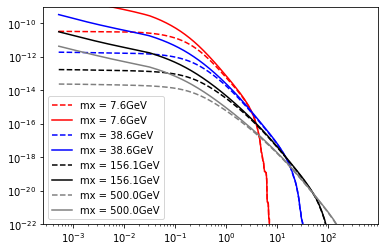

In [228]:
tex_label='electron_phasespaceE_mx'
m_inds = np.array([1, 8, 14, 19])
print(mx[m_inds])
m_ind = 10
print(mx[m_ind])
r_inds = np.array([39, 79, 119, 159, 319])
print(rr[0][r_inds])
fe = (u/(1000*rr))/(cf.cm_per_pc**3)
np.save(array_path + tex_label + '__E.npy', EE_set[:, :, 0])
np.save(array_path + tex_label + '__r.npy', rr[0, r_inds])
np.save(array_path + tex_label + '__fe.npy', fe[:, 1, :, :, r_inds])
np.save(array_path + tex_label + '__mx.npy', mx)
np.save(array_path + tex_label + '__scheme.npy', np.array([outvars[0][0], outvars[0][-1]]))
c = ['r', 'b', 'k', '.5']
for i, j in zip(m_inds, range(len(m_inds))):
    #this next line can be put back when unweighted runs are done
    plt.plot(EE_set[i][:, 0], fe[0, 1, i, :, r_inds[3]], color=c[j], linestyle='--', label=r'mx = ' + str(mx[i]) + 'GeV')
    plt.plot(EE_set[i][:, 0], fe[1, 1, i, :, r_inds[3]], color=c[j], linestyle='-', label=r'mx = ' + str(mx[i]) + 'GeV')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-22, 1e-9])
plt.legend()

In [158]:
fe[:, 1, m_inds, :, r_inds].shape

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4,) (5,) 

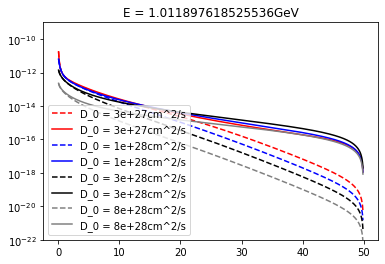

In [229]:
tex_label = 'electron_phasespacer_D0'
Eind = np.argmin(np.abs(EE_set[m_inds[1], :, 0] - 1))
np.save(array_path + tex_label + '__r.npy', rr[0])
np.save(array_path + tex_label + '__fe.npy', fe[:, :, m_inds[1], Eind, :])
np.save(array_path + tex_label + '__D0.npy', np.array(D0))
np.save(array_path + tex_label + '__E.npy', np.array(EE_set[m_inds[1], Eind, 0]))
np.save(array_path + tex_label + '__mx.npy', np.array(mx[m_inds[1]]))
np.save(array_path + tex_label + '__scheme.npy', np.array([outvars[0][0], outvars[0][-1]]))
c = ['r', 'b', 'k', '.5']
for i in range(len(D0)):
    #this next line can be put back when unweighted runs are done
    plt.plot(rr[0], fe[0, i, m_inds[1], Eind, :], color = c[i], linestyle='--', label=r'D_0 = ' + str(D0[i]) + 'cm^2/s')
    plt.plot(rr[0], fe[1, i, m_inds[1], Eind, :], color=c[i], linestyle='-', label=r'D_0 = ' + str(D0[i]) + 'cm^2/s')
plt.yscale('log')
#plt.xscale('log')
plt.title(r'E = ' + str(EE_set[m_inds[1]][Eind, 0]) + r'GeV')
plt.ylim([1e-22, 1e-9])
plt.legend()
                    

In [230]:
#extract data and coordinates
data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW = get_data_and_info(fits_path, fits_name)
dlt_N = dlt_N_deg*np.pi/180
dlt_n = dlt_n_deg*np.pi/180
HPBW = HPBW_deg*np.pi/180
sigma_BW = HPBW/(2*np.sqrt(2*np.log(2)))
omega_beam = 2*np.pi*sigma_BW**2
print('real data info extracted')
#create coords for data
ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
AX_N, AX_n = np.meshgrid(ax_N, ax_n)
THETA = np.sqrt(AX_N**2+AX_n**2)
DA = 785

real data info extracted


In [233]:
#synchrotron
run_list = mt.find_results(2, astro_model=astro_model, spherical_ave=sph_avgs, D0=D0, mx=mx)
print('number of runs: ', len(run_list))
signal_temps = np.array([gen_templates(run, nu_data, omega_beam, AX_N, AX_n) for run in run_list])
outvar_names = ['Spherical Average' ,'D0', 'mx']
signal_temps, outvars = order_output(outvar_names, signal_temps, run_list)
signal_temps = reshape_array_set(outvars, signal_temps)
print(signal_temps.shape)
avg_schemes = np.array([outvars[0][0], outvars[0][-1]])

number of runs:  160
(2, 4, 20, 155, 441)


In [232]:
outvars

[array(['unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unweighted', 'unweighted',
        'unweighted', 'unweighted', 'unw

In [237]:
tex_label = 'signal_mx'
Dind = 1
np.save(array_path + tex_label + '__x.npy', DA*AX_N)
np.save(array_path + tex_label + '__y.npy', DA*AX_n)
np.save(array_path + tex_label + '__flux.npy', signal_temps[:, Dind, m_inds, :, :])
np.save(array_path + tex_label + '__mx.npy', mx[m_inds])
np.save(array_path + tex_label + '__scheme.npy', avg_schemes)

In [238]:
tex_label = 'signal_D0'
np.save(array_path + tex_label + '__x.npy', DA*AX_N)
np.save(array_path + tex_label + '__y.npy', DA*AX_n)
np.save(array_path + tex_label + '__flux.npy', signal_temps[:, :, m_inds[1], :, :])
np.save(array_path + tex_label + '__D0.npy', D0)
np.save(array_path + tex_label + '__scheme.npy', avg_schemes)

In [239]:
tex_label = 'signal'
Dind = 1
this_D0 = D0[Dind:Dind+1]
this_mx = mx[m_inds[1]: m_inds[1]+1]
np.save(array_path + tex_label + '__x.npy', DA*AX_N)
np.save(array_path + tex_label + '__y.npy', DA*AX_n)
#may need to change the first index of signal_temps to 1 depending on the order of weighted_dl and unweighted
ind = np.where(avg_schemes=='weighted_dl')[0][0]
np.save(array_path + tex_label + '__flux.npy', signal_temps[ind, Dind, m_inds[1], :, :])
np.save(array_path + tex_label + '__D0.npy', this_D0)
np.save(array_path + tex_label + '__mx.npy', this_mx)

In [182]:
mx[m_inds[1]: m_inds[1]+1]

array([38.6])

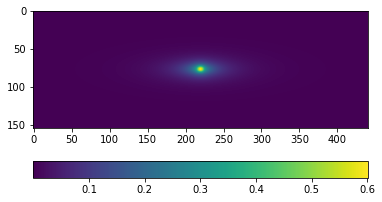

In [104]:
plt.imshow(signal_temps[0, 1, 8, :, :])
plt.colorbar(orientation='horizontal')

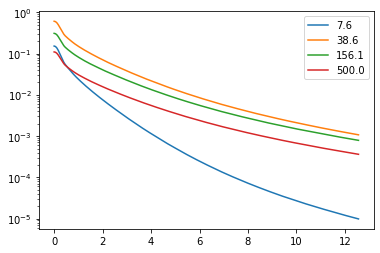

In [219]:
Dind = 1
mind = 8
N0 = int((N-1)/2)
n0 = int((n-1)/2)

for ind in m_inds:
    plt.plot(DA*AX_N[0, N0:], signal_temps[0, Dind, ind, n0, N0:], label=str(mx[ind]))
plt.yscale('log')
plt.legend()

In [241]:
#synchrotron
astro_models = ['Andromeda5', 'Andromeda5_lowrad']
sph_avg = 'weighted_dl'
D0 = np.array([3e27, 1e28, 3e28, 8e28])
mx=np.array([38.6])
run_list = mt.find_results(2, astro_model=astro_models, spherical_ave=sph_avg, D0=D0, mx=mx)
print('number of runs: ', len(run_list))
signal_temps = np.array([gen_templates(run, nu_data, omega_beam, AX_N, AX_n) for run in run_list])
outvar_names = ['Astrophysical Model' ,'D0']
signal_temps, outvars = order_output(outvar_names, signal_temps, run_list)
signal_temps = reshape_array_set(outvars, signal_temps)
print(signal_temps.shape)

number of runs:  8
(2, 4, 155, 441)


In [191]:
print(outvars)

[array(['Andromeda5', 'Andromeda5', 'Andromeda5', 'Andromeda5',
       'Andromeda5_lowrad', 'Andromeda5_lowrad', 'Andromeda5_lowrad',
       'Andromeda5_lowrad'], dtype='<U17'), array([3.e+27, 1.e+28, 3.e+28, 8.e+28, 3.e+27, 1.e+28, 3.e+28, 8.e+28])]


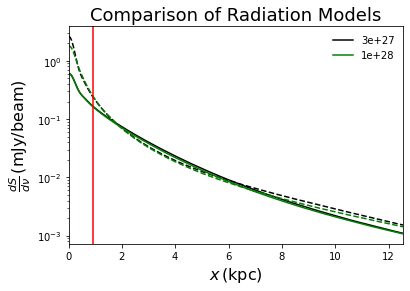

In [248]:
N0 = int((N-1)/2)
n0 = int((n-1)/2)
c = ['k', 'g', 'r', 'b']
for i in range(len(D0)-2):
    plt.plot(DA*AX_N[n0, N0:], signal_temps[0, i, n0, N0:], label=str(D0[i]), linestyle='-', color=c[i])
    plt.plot(DA*AX_N[n0, N0:], signal_temps[1, i, n0, N0:], linestyle='--', color=c[i])
plt.axvline(x=0.93, color='r')
plt.yscale('log')
plt.xlabel(r'$x \, \rm(kpc)$', size=16)
plt.ylabel(r'$\frac{dS}{d\nu} \, \rm (mJy/beam)$', size=16)
plt.title(r'Comparison of Radiation Models', size=18)
plt.xlim([0, DA*AX_N[n0, -1]])
plt.legend(frameon=False)
plt.savefig(base_path + 'figs/compare_rad_models.pdf' )

In [110]:
base = np.ones((4,5))
arr = np.array([i*base for i in range(6)])
print(arr)
new_arr = arr.reshape((1, 2, 3, 4, 5))
print(new_arr[0, 1, 2])
new_arr/np.ones((4,5))

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2.]]

 [[3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]
  [3. 3. 3. 3. 3.]]

 [[4. 4. 4. 4. 4.]
  [4. 4. 4. 4. 4.]
  [4. 4. 4. 4. 4.]
  [4. 4. 4. 4. 4.]]

 [[5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5.]]]
[[5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]]


array([[[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],

         [[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]],

         [[2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2.]]],


        [[[3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.],
          [3., 3., 3., 3., 3.]],

         [[4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4.]],

         [[5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5.]]]]])

In [168]:
x = 156
num_dig = np.floor(np.log10(x))+1
y = x/10**num_dig
y = np.round(y, 2)
res = y*10**num_dig
print(res)

160.0
